# Dataset

For this project, you will use the **ShanghaiTech Dataset**, a standard benchmark for evaluating crowd counting models. It consists of 800 real-world crowd images annotated with 330'000 point locations corresponding to individual heads. The dataset is divided into two parts.
- **Part A:** Images collected from the internet with highly congested scenes and large crowd densities.
- **Part B:** Images collected from street scenes in Shanghai with moderately crowded scenes and more regular perspective and scale.

Each image is accompanied by a set of head-point annotations, typically stored as a list of 2D coordinates.

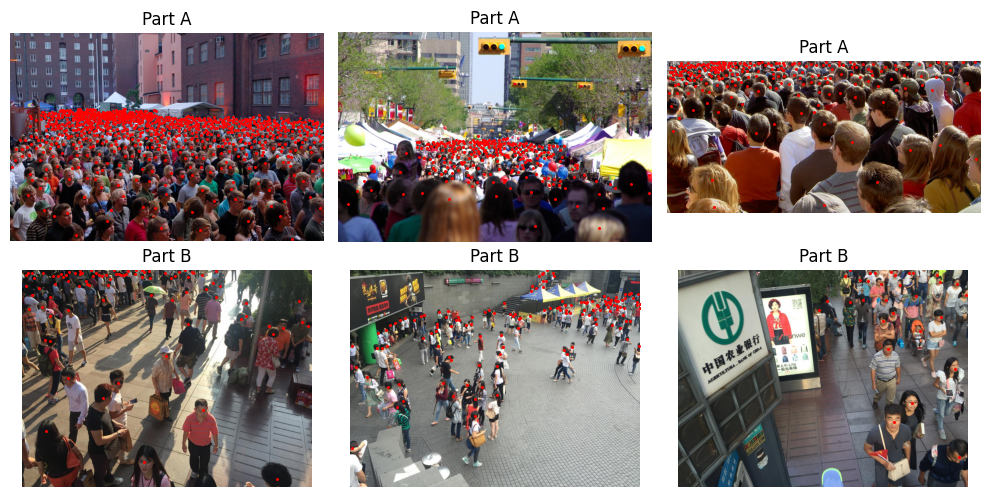

In [1]:
import matplotlib.pyplot as plt
from solution.CSRNet.dataset import ShanghaiTechDataset

ds_a = ShanghaiTechDataset("solution/.data/", part='A')
ds_b = ShanghaiTechDataset("solution/.data/", part='B')

plt.figure(figsize=(10, 5), tight_layout=True)
for i, ds in enumerate([ds_a, ds_b]):
    for j in range(1, 4):
        image, points = ds[j+10]
        plt.subplot(2, 3, i * 3 + j)
        plt.imshow(image)
        plt.scatter(points[:, 0], points[:, 1], s=5, marker='.', c='r')
        plt.title(f"Part {ds.part}")
        plt.axis('off')
plt.show()

## Download the images

You can download the ShanghaiTech Dataset by following the link provided on [GitHub](https://github.com/desenzhou/ShanghaiTechDataset), or from [Kaggle](https://www.kaggle.com/datasets/tthien/shanghaitech) if you have an account. Ensure you download both Part A and Part B of the dataset. Alternatively, you can download the following files and extract them using any unzip tool that supports multi-part archives, such as [7-Zip](https://www.7-zip.org/).
- [Part 1](./files/ShanghaiTech.zip)
- [Part 2](./files/ShanghaiTech.z01)

Unpack the downloaded files in your project directory, so that the folder structure looks like this.

```bash
Project
│
├── .data
│   └── ShanghaiTech
│       │
│       ├── part_A_final
│       │   │
│       │   ├── train_data
│       │   │   ├── images
│       │   │   │   ├── IMG_1.jpg
│       │   │   │   ├── IMG_2.jpg
│       │   │   │   └── ...
│       │   │   └── ground_truth
│       │   │       ├── GT_IMG_1.mat
│       │   │       ├── GT_IMG_2.mat
│       │   │       └── ...
│       │   │
│       │   └── test_data
│       │       ├── images
│       │       │   ├── IMG_1.jpg
│       │       │   ├── IMG_2.jpg
│       │       │   └── ...
│       │       └── ground_truth
│       │           ├── GT_IMG_1.mat
│       │           ├── GT_IMG_2.mat
│       │           └── ...
│       │
│       └── part_B_final
│           ├── train_data
│           └── test_data
```


## PyTorch wrapper

The ShanghaiTech data can be conveniently loaded using the custom PyTorch `Dataset` provided below. The constructor expects a path pointing to the folder that contains the `ShanghaiTech` directory, and allows you to select *Part A* or *Part B* via the `part` argument and the training or test split via the `split` argument. For each index, the method `__getitem__` returns a tuple `(image, points)`, where `image` is a PIL RGB image and `points` is a Python list of (x, y) coordinates (in pixel units) corresponding to annotated head locations. The class also supports optional transforms: 
- `transform` for image-only transformations, 
- `target_transform` for target-only transformations, 
- `transforms` for joint transformations that operate on both image and points simultaneously (for example, resizing or cropping that must keep the coordinates consistent with the image). 

This design lets you reuse the same dataset implementation for both CSRNet and P2PNet models, which only differ in the preprocessing steps provided via the transform arguments.

In [ ]:
from torchvision.datasets.vision import VisionDataset
from pathlib import Path
from PIL import Image
import scipy.io as sio


class ShanghaiTechDataset(VisionDataset):

    def __init__(self, root_dir, part="A", split="train", transform=None, target_transform=None, transforms=None):
        """
        Args:
            root_dir (str): 
                Path to the directory containing the "ShanghaiTech" folder.
            part (str): 
                Either "A" or "B", selecting ShanghaiTech Part A or Part B.
            split (str):
                Either "train" or "test", selecting the corresponding split.
            transform (callable, optional): 
                A function applied only to the input image (a PIL RGB image).
            target_transform (callable, optional):
                A function applied only to the target (a list of (x, y) head-point coordinates).
            transforms (callable, optional): 
                A function applied to both image and target that returns transformed versions of both.
        """
        super().__init__(root=root_dir, transform=transform, target_transform=target_transform, transforms=transforms)
        self.part = part
        self.split = split
        self.root = Path(root_dir) / "ShanghaiTech"
        self.img_dir = self.root / f"part_{part}_final" / f"{split}_data" / "images"
        self.gt_dir  = self.root / f"part_{part}_final" / f"{split}_data" / "ground_truth"
        self.image_files = sorted([p for p in self.img_dir.iterdir() if p.suffix == ".jpg"])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        gt_path  = self.gt_dir / f"GT_{img_path.stem}.mat"

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load ground truth (MATLAB file)
        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0,0][0,0][0]  # Nx2 array of head annotations
        points = points.tolist()

        # Apply transforms (inherited from VisionDataset)
        if self.transforms is not None:
            image, points = self.transforms(image, points)

        return image, points
